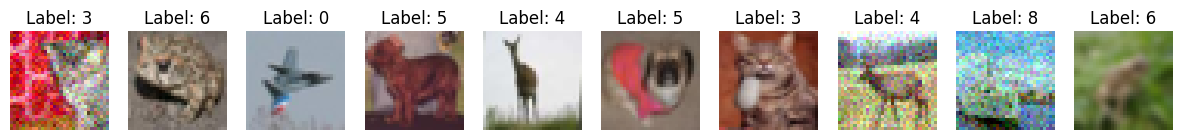

In [4]:
# 1. Data processing V1

#Noise Addition

#Adding random noise to the images helps the model generalize to noisy or imperfect data, which is common in real-world applications like medical imaging, security, or remote sensing.

 #• Gaussian Noise:
 #• Adds Gaussian noise to simulate noisy input data.
 #• Helps the model become robust to noisy images (e.g., grainy or low-quality images).
 #• Example (custom): def add_gaussian_noise(image, mean=0, std=0.1):
  #  noise = torch.randn(image.size()) * std + mean
   # noisy_image = image + noise
    # return torch.clamp(noisy_image, 0., 1.)

import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# Function to apply Gaussian noise
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 0.1  # Adjust sigma to control noise level
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values remain in [0, 1]
    return noisy_image

# Function to apply Gaussian blur
def apply_gaussian_blur(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)  # Kernel size of 5x5
    return blurred_image

# Load CIFAR-10 batch
def load_cifar_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Load all batches
batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
batches = [load_cifar_batch(batch_file) for batch_file in batch_files]
test_batch = load_cifar_batch('test_batch')

# Extract 40% of each batch
train_data = []
train_labels = []
for batch in batches:
    data = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    labels = np.array(batch[b'labels'])

    # Sample 20% of the batch
    data_sample, _, labels_sample, _ = train_test_split(data, labels, test_size=0.01, stratify=labels, random_state=42)

    train_data.append(data_sample)
    train_labels.append(labels_sample)

# Combine the 20% samples from each batch
train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Test data
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
test_labels = np.array(test_batch[b'labels'])

# Split train data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Apply Gaussian noise and Gaussian blur during augmentation
def custom_augment(image):
    if np.random.rand() > 0.5:
        image = add_gaussian_noise(image)
    if np.random.rand() > 0.5:
        image = apply_gaussian_blur(image)
    return image

# Custom data generator
def custom_data_generator(datagen, data, labels, batch_size):
    gen = datagen.flow(data, labels, batch_size=batch_size)
    while True:
        data_batch, label_batch = next(gen)
        for i in range(data_batch.shape[0]):
            data_batch[i] = custom_augment(data_batch[i])
        yield data_batch, label_batch

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_data)

# Visualizing some augmented images
def show_augmented_images(data, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        img = custom_augment(data[i])
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Show first 10 images from the 20% sampled and augmented training set
show_augmented_images(train_data, train_labels)

In [5]:
# 2 Model Architecture V1

# Improvements: Activation change / lu

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,042 (890.79 KB)

 Trainable params: 227,594 (889.04 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
### 3. Model Training


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model with custom augmentation
history = model.fit(custom_data_generator(datagen, train_data, train_labels, batch_size=64),
                    steps_per_epoch=len(train_data) // 64,
                    epochs=50,
                    validation_data=(val_data, val_labels),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.2985 - loss: 2.0760 - val_accuracy: 0.4313 - val_loss: 1.5405 - learning_rate: 0.0010
Epoch 2/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4326 - loss: 1.5793 - val_accuracy: 0.4665 - val_loss: 1.5302 - learning_rate: 0.0010
Epoch 3/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4760 - loss: 1.4557 - val_accuracy: 0.5153 - val_loss: 1.3895 - learning_rate: 0.0010
Epoch 4/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.5106 - loss: 1.3704 - val_accuracy: 0.5357 - val_loss: 1.3324 - learning_rate: 0.0010
Epoch 5/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5350 - loss: 1.3137 - val_accuracy: 0.5905 - val_loss: 1.1781 - learning_rate: 0.0010
Epoch 6/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5522 - loss: 1.2548 - val_accuracy: 0.6238 - val_loss: 1.0489 - learning_rate: 0.0010
Epoch 7/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5704 - l

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7878 - loss: 0.6167
Validation Accuracy: 0.7890
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80       955
           1       0.88      0.91      0.89      1000
           2       0.71      0.73      0.72      1024
           3       0.66      0.65      0.65      1050
           4       0.78      0.73      0.75       941
           5       0.73      0.63      0.68       965
           6       0.83      0.86      0.84      1021
           7       0.80      0.85      0.83       948
           8       0.86      0.85      0.86       983
           9       0.85      0.86      0.86      1013

    accuracy                           0.79      9900
   macro avg       0.79      0.79      0.79      9900
weighted avg       0.79      0.79      0.79      9900



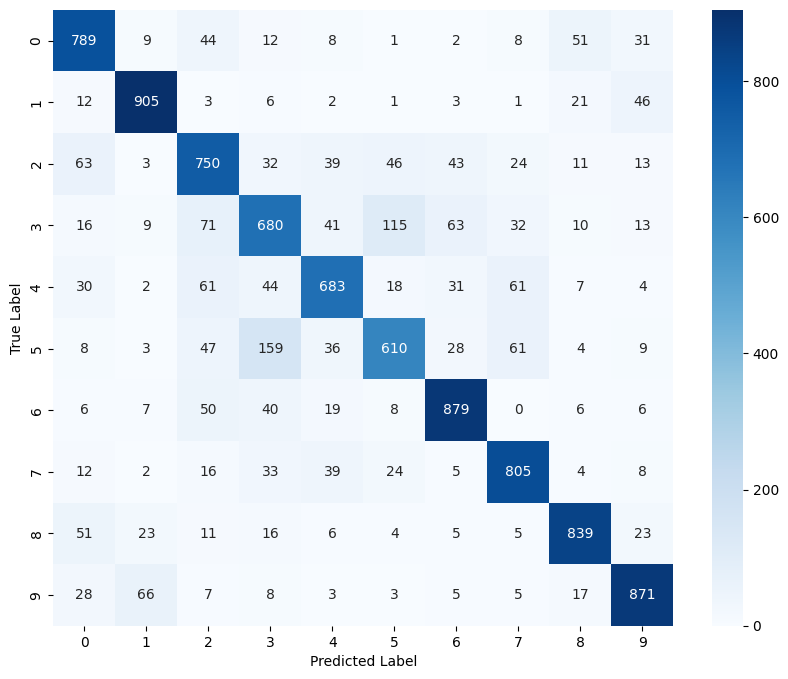

In [9]:
#4. Model evaluation V1

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predictions
val_pred = np.argmax(model.predict(val_data), axis=1)

# Classification report
print("Classification Report:\n", classification_report(val_labels, val_pred))

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
model.save('/content/drive/MyDrive/Colab Notebooks/model.h5')  # HDF5 format

In [8]:
#step 5 transfer learning


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load VGG16 pre-trained on ImageNet without the top layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the pre-trained convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

# Build transfer learning model
transfer_model = Sequential()
transfer_model.add(vgg_model)
transfer_model.add(GlobalAveragePooling2D())  # Global average pooling instead of flattening
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(10, activation='softmax'))

# Compile the transfer learning model
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the transfer learning model
history_transfer = transfer_model.fit(custom_data_generator(datagen, train_data, train_labels, batch_size=64),
                                      steps_per_epoch=len(train_data) // 64,
                                      epochs=30,
                                      validation_data=(val_data, val_labels),
                                      callbacks=[early_stopping, reduce_lr])

# Evaluate the transfer learning model
val_loss_transfer, val_accuracy_transfer = transfer_model.evaluate(val_data, val_labels)
print(f"Transfer Learning Validation Accuracy: {val_accuracy_transfer:.4f}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
 69/618 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.1895 - loss: 2.2639

KeyboardInterrupt: 

In [ ]:
# improved version of inception

import numpy as np
import cv2
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load CIFAR-10 dataset
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

# Normalize the data to be in the range [0, 1]
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Split the training data further into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

# Function to resize images to a target size (now 75x75 for faster training)
def resize_images(data, size=(75, 75)):
    resized_data = np.array([cv2.resize(img, size) for img in data])
    return resized_data

# Resize CIFAR-10 images to 75x75 to match InceptionV3 input size
train_data_resized = resize_images(train_data, size=(75, 75))
val_data_resized = resize_images(val_data, size=(75, 75))
test_data_resized = resize_images(test_data, size=(75, 75))

# Simpler data augmentation (rotation, zoom, and flipping)
datagen = ImageDataGenerator(
    rotation_range=20,        # Moderate rotation
    zoom_range=0.2,           # Zoom in/out on images
    horizontal_flip=True,     # Horizontal flipping
    fill_mode='nearest'       # Fill mode for shifted pixels
)
datagen.fit(train_data_resized)

# Load InceptionV3 pre-trained on ImageNet without the top layers
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze all layers except the last 20 for fine-tuning
for layer in inception_model.layers[:-20]:
    layer.trainable = False

# Build the transfer learning model
transfer_model = Sequential()
transfer_model.add(inception_model)
transfer_model.add(GlobalAveragePooling2D())  # Global average pooling instead of flattening
transfer_model.add(Dense(256, activation='relu'))  # Only one dense layer to reduce complexity
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(10, activation='softmax'))  # Output layer for CIFAR-10 (10 classes)

# Compile the transfer learning model with a moderate learning rate
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Moderate learning rate
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

# Train the transfer learning model
history_transfer = transfer_model.fit(
    datagen.flow(train_data_resized, train_labels, batch_size=64),
    steps_per_epoch=len(train_data_resized) // 64,
    epochs=30,  # Reduced number of epochs for faster training
    validation_data=(val_data_resized, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the fine-tuned transfer learning model
val_loss_transfer, val_accuracy_transfer = transfer_model.evaluate(val_data_resized, val_labels)
print(f"InceptionV3 Transfer Learning Validation Accuracy: {val_accuracy_transfer:.4f}")

# Evaluate on test data
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_data_resized, test_labels)
print(f"InceptionV3 Transfer Learning Test Accuracy: {test_accuracy_transfer:.4f}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


703/703 ━━━━━━━━━━━━━━━━━━━━ 101s 120ms/step - accuracy: 0.4245 - loss: 1.6698 - val_accuracy: 0.6230 - val_loss: 1.0731 - learning_rate: 1.0000e-04
Epoch 2/30
  1/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6875 - loss: 0.9874

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.9874 - val_accuracy: 0.6248 - val_loss: 1.0737 - learning_rate: 1.0000e-04
Epoch 3/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.6136 - loss: 1.1151 - val_accuracy: 0.6740 - val_loss: 0.9234 - learning_rate: 1.0000e-04
Epoch 4/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6406 - loss: 0.9833 - val_accuracy: 0.6750 - val_loss: 0.9236 - learning_rate: 1.0000e-04
Epoch 5/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.6423 - loss: 1.0267 - val_accuracy: 0.6892 - val_loss: 0.8772 - learning_rate: 1.0000e-04
Epoch 6/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.2609 - val_accuracy: 0.6896 - val_loss: 0.8750 - learning_rate: 1.0000e-04
Epoch 7/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.6580 - loss: 0.9865 - val_accuracy: 0.6968 - val_loss: 0.8785 - learning_rate: 1.0000e-04
Epoch 8/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.609

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
